# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 1: Solve the displacement field $u(x)$ given the Young’s modulus $E(x)$
Young’s modulus $E(x)$ is given as a piecewise-constant function:
$$
E(x)=
\begin{cases}
5.\quad 0.15<|x-0.5|<0.35 \\
2.\quad otherwise
\end{cases}
$$

### The goals
- Please select a suitable deep learning method for solving this problem to obtain the displacement field $u(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve ( and report the final error). The $L^2$ relative error between the prediction $u_{pred}$ and the truth $u_{true}$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|u_{pred}(x_i)-u_{true}(x_i)|^2}{\sum^{n}_{i}|u_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The ground truth reference is given in the dataset ```LinearElasticity1d.h5```:
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```u_test```: the ground truth reference (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
print(f"Using device: {device}")

torch.manual_seed(1234)

Using device: cpu


### Dataset

In [2]:
# Open the .h5 file in read mode
with h5py.File("LinearElasticity1d.h5", "r") as file:
    # Print the names of the datasets in the file
    print(file.keys())
    # Load the test data
    x_test = torch.tensor(np.array(file["x_test"]), dtype=dtype)
    u_test = torch.tensor(np.array(file["u_test"]), dtype=dtype).unsqueeze(1)
    
# Get the number of samples in the test set
n_int = 10000

print("\nTesting dataset...")
print("Size of x_test:", x_test.shape)
print("Size of u_test:", u_test.shape)

# Compute integration points and weights using Gauss-Legendre quadrature
x_int, w_int = np.polynomial.legendre.leggauss(n_int)
x_int = x_int * 0.5 + 0.5  # Scale to [0, 1]
x_int, w_int = torch.tensor(x_int, dtype=dtype).unsqueeze(1), torch.tensor(w_int, dtype=dtype).unsqueeze(1)

print("\nIntegration points and weights...")
print("Size of x_int:", x_int.shape)
print("Size of w_int:", w_int.shape)

# Compute boundary points and values
x_bd = torch.tensor([[0.], [1.]], dtype=dtype)
u_bd = torch.tensor([[0.], [0.]], dtype=dtype)

print("\nBoundary points...")
print("Size of x_bd:", x_bd.shape)
print("Size of u_bd:", u_bd.shape)

# Young's modulus
def E(x, phase1=2., phase2=5.):
    """Young's modulus"""
    return torch.where(
        torch.abs(x-0.5)<0.35, 
        torch.where(torch.abs(x-0.5)>0.15, phase2, phase1), 
        phase1
    )

e = E(x_int)

print("\nYoung's modulus...")
print("Size of e:", e.shape)


<KeysViewHDF5 ['u_test', 'x_test']>

Testing dataset...
Size of x_test: torch.Size([1001, 1])
Size of u_test: torch.Size([1001, 1])

Integration points and weights...
Size of x_int: torch.Size([10000, 1])
Size of w_int: torch.Size([10000, 1])

Boundary points...
Size of x_bd: torch.Size([2, 1])
Size of u_bd: torch.Size([2, 1])

Young's modulus...
Size of e: torch.Size([10000, 1])


### Neural Network Architecture

In [3]:
from torchsummary import summary

class ResidualNN(nn.Module):
    """Residual MLP using custom activation and residual blocks."""
    def __init__(self, layers: list, dtype=None):
        super().__init__()
        assert len(layers) % 2 == 1, "Layers must have odd length"
        
        self.net = nn.ModuleList()
        hidden_in = layers[0]
        for hidden_out in layers[1:]:
            self.net.append(nn.Linear(hidden_in, hidden_out, dtype=dtype))
            hidden_in = hidden_out

    def activation(self, x):
        """Cubic relu activation function."""
        return torch.relu(x ** 3)

    def block(self, s, net1, net2):
        """Residual block with two linear layers and custom activation."""
        # Forward pass through the two linear layers with activation
        x = self.activation(net1(s))
        x = self.activation(net2(x))
        # Add the input to the output (residual connection)
        return x + s

    def forward(self, s):
        # Forward pass through each of the residual blocks
        for i in range((len(self.net) - 1) // 2):
            s = self.block(s, self.net[2*i], self.net[2*i + 1])
        # Final layer without activation
        return self.net[-1](s)

class MLP(nn.Module):
    """Residual MLP using custom activation and residual blocks."""
    def __init__(self, layers: list, dtype=None):
        super().__init__()
        
        self.net = nn.ModuleList()
        hidden_in = layers[0]
        for hidden_out in layers[1:]:
            self.net.append(nn.Linear(hidden_in, hidden_out, dtype=dtype))
            hidden_in = hidden_out

    def activation(self, x):
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
    
    def forward(self, x):
        # Forward pass through each of the residual blocks
        for layer in self.net[:-1]:
            x = self.activation(layer(x))
        return self.net[-1](x)

m = 80
u_model = MLP([1, m, m, m, m, m, 1], dtype = torch.float32).to(device)
summary(u_model, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 80]             160
            Linear-2                   [-1, 80]           6,480
            Linear-3                   [-1, 80]           6,480
            Linear-4                   [-1, 80]           6,480
            Linear-5                   [-1, 80]           6,480
            Linear-6                    [-1, 1]              81
Total params: 26,161
Trainable params: 26,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


ValueError: x and y must have same first dimension, but have shapes (1001, 1) and (10000, 1)

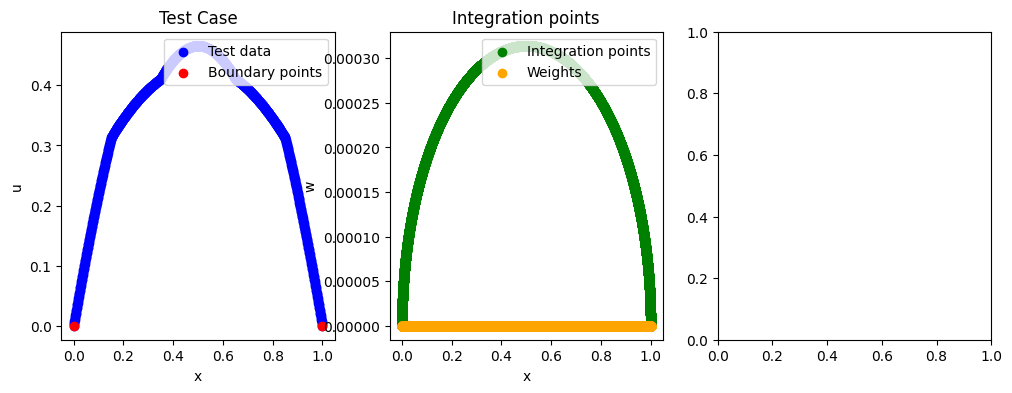

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(x_test, u_test, color='blue', label='Test data')
axs[0].scatter(x_bd, u_bd, color='red', label='Boundary points')
axs[0].set_title('Test Case')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u')
axs[0].legend(loc='upper right')

axs[1].scatter(x_int, w_int, color='green' , label='Integration points')
axs[1].scatter(x_int, torch.zeros_like(x_int), color='orange', label='Weights')
axs[1].set_title('Integration points')
axs[1].set_xlabel('x')
axs[1].set_ylabel('w')
axs[1].legend(loc='upper right')

axs[2].plot(x_test, e)
axs[2].set_title("Young\'s modulus")
axs[2].set_xlabel(f"x")
axs[2].set_ylabel(f"E(x)")

plt.tight_layout()
plt.show()

### Loss and Error

In [ ]:
from torch.autograd import grad, Variable

class Mollifier(object):
    """Mollifier to ensure zero boundary conditions."""
    def __init__(self):
        pass

    def __call__(self, u, x):
        """Apply the mollifier to a displacement field."""
        return x * (1 - x) * u
        #return u * torch.sin(torch.pi * x)

class LossClass(object):
    """Loss function for the Deep-Ritz method."""
    def __init__(self, u_model, x_int, w_int, x_bd, u_bd, e, f=9.81, device="cpu", mollifier: Mollifier = None):
        # Store model and mollifier
        self.u_model = u_model.to(device)
        self.mollifier = mollifier
        # Store integration points and weights enable gradient computation
        self.x = Variable(x_int, requires_grad=True).to(device)
        self.w = w_int.to(device)
        # Store boundary points and values
        self.x_bd = x_bd.to(device)
        self.u_bd = u_bd.to(device)
        # Store Young's modulus and external forces
        self.e = e.to(device)
        self.f = torch.ones_like(self.x) * f

    def _pde_loss(self):
        """Compute the PDE loss at integration points."""
        # Predict displacement field and apply mollifier
        u = self.u_model(self.x)
        if self.mollifier is not None:
            u = self.mollifier(u, self.x)
        # Compute gradient of u with respect to x
        du_dx = grad(inputs=self.x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Compute the energy functional at every integration point
        energy = (0.5 * self.e * du_dx**2 - self.f * u) * self.w * 0.5
        # Integrate the energy functional over the domain
        loss = torch.sum(energy)
        return loss
    
    def _bd_loss(self):
        """Compute the boundary loss at boundary points."""
        # Predict displacement field and apply mollifier
        u = self.u_model(self.x_bd)
        if self.mollifier is not None:
            u = self.mollifier(u, self.x_bd)
        # Compute the boundary residual at every boundary point
        res = u - self.u_bd
        # Integrate the boundary residual over the domain boundaries
        loss = torch.sum(res**2)
        return loss

    def __call__(self, bd_weight=0.0):
        """Compute the energy functional loss."""
        # Compute total loss as a weighted sum of PDE and boundary losses
        loss = self._pde_loss()
        if bd_weight > 0.0:
            loss += bd_weight * self._bd_loss()
        return loss
    
class ErrorClass(object):
    """Prediction error."""
    def __init__(self, u_model, x_test, u_test, device="cpu", mollifier: Mollifier = None):
        # Store model and mollifier
        self.u_model = u_model.to(device)
        self.mollifier = mollifier
        # Store test data
        self.x_test = x_test.to(device)
        self.u_test = u_test.to(device)

    def __call__(self):
        """Compute the L2 relative error of the prediction."""
        # Predict displacement field and apply mollifier
        u_pred = self.u_model(self.x_test)
        if self.mollifier is not None:
            u_pred = self.mollifier(u_pred, self.x_test)
        # Compute the mean squared error
        num = torch.sum((u_pred - self.u_test)**2, dim=0)
        den = torch.sum(self.u_test**2, dim=0)
        error = torch.sqrt(num/den)
        return error

### Optimization Loop (Soft-Constraint Boundary Conditions)

In [16]:
from tqdm import trange
import time

epochs = 10000
lr = 1e-3

u_model_soft= MLP([1, m, m, m, m, m, 1], dtype = torch.float32).to(device)
optimizer = torch.optim.Adam(params=u_model_soft.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
loss_class = LossClass(u_model_soft, x_int, w_int, x_bd, u_bd, e)
error_class = ErrorClass(u_model_soft, x_test, u_test)

error_list_soft, loss_list_soft, lr_list_soft = [], [], []
time_start = time.time()
for epoch in trange(epochs, desc="Training", leave=True):
    # Zero gradients
    optimizer.zero_grad()
    # Compute loss
    loss = loss_class(bd_weight=1000.0)
    # Backpropagate the loss and update model parameters 
    loss.backward()
    optimizer.step()
    # Compute error
    with torch.no_grad():
        error = error_class()
        loss_list_soft.append(loss.item())
        error_list_soft.append(error.item())
        lr_list_soft.append(scheduler.get_last_lr()[0])
    # Update the learning rate
    scheduler.step()
    # Print loss and error every 100 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Error: {error.item():.4f}, Learning rate: {scheduler.get_last_lr()[0]:.6f}")
time_end = time.time()
print(f"Training completed in {time_end - time_start:.2f} seconds.")

Training:   5%|▌         | 502/10000 [00:21<06:50, 23.16it/s]

Epoch 500/10000, Loss: -1.5992, Error: 0.0225, Learning rate: 0.001000


Training:  10%|█         | 1003/10000 [00:43<05:53, 25.45it/s]

Epoch 1000/10000, Loss: -1.5967, Error: 0.0190, Learning rate: 0.001000


Training:  15%|█▌        | 1504/10000 [01:04<06:07, 23.13it/s]

Epoch 1500/10000, Loss: -1.5694, Error: 0.0510, Learning rate: 0.001000


Training:  20%|██        | 2002/10000 [01:26<05:21, 24.90it/s]

Epoch 2000/10000, Loss: -1.4205, Error: 0.0723, Learning rate: 0.000500


Training:  25%|██▌       | 2504/10000 [01:51<05:53, 21.18it/s]

Epoch 2500/10000, Loss: -1.5990, Error: 0.0217, Learning rate: 0.000500


Training:  30%|███       | 3003/10000 [02:17<05:45, 20.24it/s]

Epoch 3000/10000, Loss: -1.5118, Error: 0.0202, Learning rate: 0.000500


Training:  35%|███▌      | 3503/10000 [02:41<05:06, 21.22it/s]

Epoch 3500/10000, Loss: -1.5986, Error: 0.0186, Learning rate: 0.000500


Training:  40%|████      | 4003/10000 [03:08<04:37, 21.60it/s]

Epoch 4000/10000, Loss: -1.5815, Error: 0.0220, Learning rate: 0.000250


Training:  45%|████▌     | 4502/10000 [03:32<04:19, 21.17it/s]

Epoch 4500/10000, Loss: -1.6011, Error: 0.0204, Learning rate: 0.000250


Training:  50%|█████     | 5002/10000 [03:58<03:59, 20.85it/s]

Epoch 5000/10000, Loss: -1.5988, Error: 0.0169, Learning rate: 0.000250


Training:  55%|█████▌    | 5503/10000 [04:25<04:08, 18.13it/s]

Epoch 5500/10000, Loss: -1.4403, Error: 0.0218, Learning rate: 0.000250


Training:  60%|██████    | 6001/10000 [04:55<07:25,  8.97it/s]

Epoch 6000/10000, Loss: -1.5954, Error: 0.0242, Learning rate: 0.000125


Training:  65%|██████▌   | 6502/10000 [05:23<03:02, 19.22it/s]

Epoch 6500/10000, Loss: -1.6058, Error: 0.0180, Learning rate: 0.000125


Training:  70%|███████   | 7002/10000 [05:49<02:25, 20.63it/s]

Epoch 7000/10000, Loss: -1.6078, Error: 0.0170, Learning rate: 0.000125


Training:  75%|███████▌  | 7502/10000 [06:14<02:12, 18.90it/s]

Epoch 7500/10000, Loss: -1.6060, Error: 0.0154, Learning rate: 0.000125


Training:  80%|████████  | 8004/10000 [06:39<01:32, 21.59it/s]

Epoch 8000/10000, Loss: -1.6113, Error: 0.0150, Learning rate: 0.000063


Training:  85%|████████▌ | 8504/10000 [07:04<01:13, 20.32it/s]

Epoch 8500/10000, Loss: -1.6129, Error: 0.0139, Learning rate: 0.000063


Training:  90%|█████████ | 9002/10000 [07:29<00:51, 19.55it/s]

Epoch 9000/10000, Loss: -1.6144, Error: 0.0128, Learning rate: 0.000063


Training:  95%|█████████▌| 9503/10000 [07:56<00:27, 18.16it/s]

Epoch 9500/10000, Loss: -1.6157, Error: 0.0121, Learning rate: 0.000063


Training: 100%|██████████| 10000/10000 [08:21<00:00, 19.92it/s]

Epoch 10000/10000, Loss: -1.6116, Error: 0.0122, Learning rate: 0.000031
Training completed in 501.91 seconds.


In [17]:
# Result plotting functions

def plot_prediction(x_query, u_query, x_test, u_test, ax):
    """Plot the predicted u against the query points."""
    ax.plot(x_query, u_query, label=r"Predicted $u$")
    ax.grid(True, linestyle='-', alpha=1.0)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$")
    ax.legend(loc="upper right")

def plot_true(x_query, u_query, x_test, u_test, ax):
    """Plot the true u against the query points."""
    ax.plot(x_test, u_test, label=r"Ground truth $u$")
    ax.grid(True, linestyle='-', alpha=1.0)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$")
    ax.legend(loc="upper right")

def plot_error_list(error_list, ax):
    """Plot the error list."""
    ax.semilogy(error_list, label=r"$L^2$ relative error")
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.set_xlabel(r"epoch")
    ax.set_ylabel(r"error")

def plot_pointwise_absolute_error(u_test, u_query, x_query, ax):
    """Plot the pointwise absolute error."""
    # Prepare dimensions for manual error calculation
    u_query = u_query.view(-1)
    u_test = u_test.view(-1)

    # Calculate pointwise absolute error
    abs_error = torch.abs(u_test - u_query)

    ax.semilogy(x_query, abs_error, label="Pointwise absolute error")
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$|u_{pred} - u_{true}|$")

The absolute $L^2$ relative error is: 0.012190860696136951


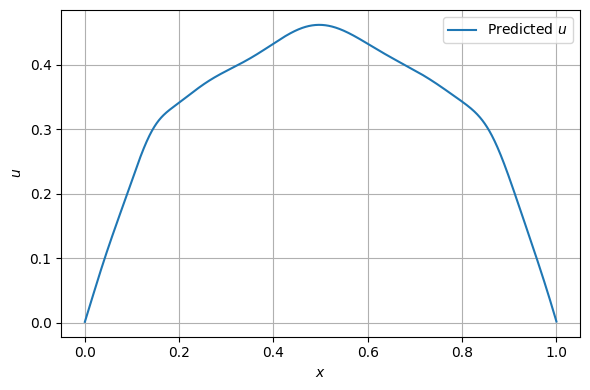

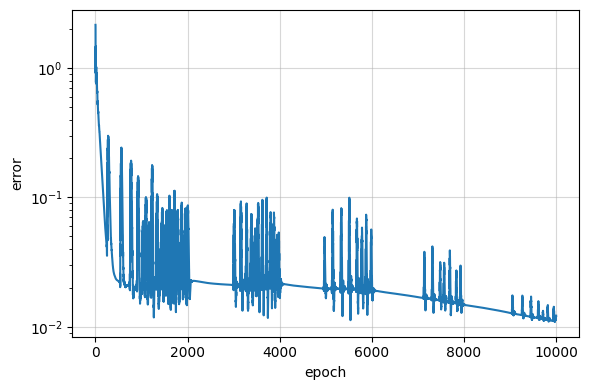

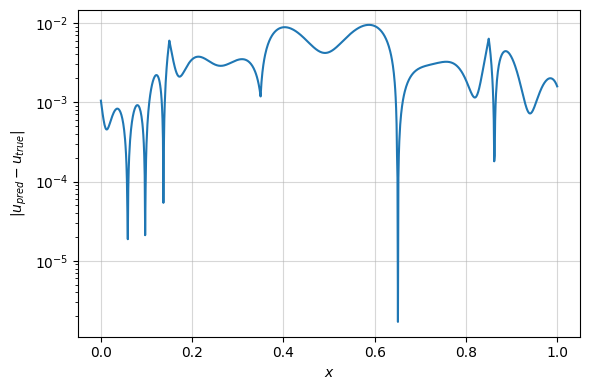

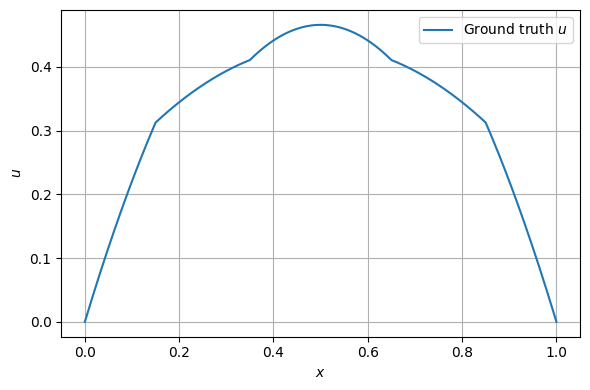

In [18]:

# Query points for prediction
x_query = x_test.to(device)
# Predict the displacement field u at query points
u_query = u_model_soft(x_query).detach().cpu()

print(r"The absolute $L^2$ relative error is:", error_class().item())

# Plot 1: Prediction vs. True
fig1, ax1 = plt.subplots(figsize=(6, 4))
plot_prediction(x_query, u_query, x_test, u_test, ax1)
fig1.tight_layout()
fig1.savefig("task1_soft_pred.pdf")
plt.show()

# Plot 2: Error vs. Epoch
fig2, ax2 = plt.subplots(figsize=(6, 4))
plot_error_list(error_list_soft, ax2)
fig2.tight_layout()
fig2.savefig("task1_soft_error_vs_epoch.pdf")
plt.show()

# Plot 3: Pointwise absolute error
fig3, ax3 = plt.subplots(figsize=(6, 4))
plot_pointwise_absolute_error(u_test, u_query, x_query, ax3)
fig3.tight_layout()
fig3.savefig("task1_soft_pointwise_absolute_error.pdf")
plt.show()

# Plot 4: Ground truth
fig4, ax4 = plt.subplots(figsize=(6, 4))
plot_true(x_query, u_query, x_test, u_test, ax4)
fig4.tight_layout()
fig4.savefig("task1_soft_true.pdf")
plt.show()

### Optimization Loop (Hard-Constraint Boundary Conditions)

In [14]:
from tqdm import trange
import time

u_model_hard = MLP([1, m, m, m, m, m, 1], dtype = torch.float32).to(device)

epochs = 10000
lr = 1e-3

optimizer = torch.optim.Adam(params=u_model_hard.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
mollifier = Mollifier()
loss_class = LossClass(u_model_hard, x_int, w_int, x_bd, u_bd, e, mollifier=mollifier)
error_class = ErrorClass(u_model_hard, x_test, u_test, mollifier=mollifier)

error_list_hard, loss_list_hard, lr_list_hard = [], [], []
time_start = time.time()
for epoch in trange(epochs):
    # Zero gradients
    optimizer.zero_grad()
    # Compute loss
    loss = loss_class()
    # Backpropagate the loss and update model parameters 
    loss.backward()
    optimizer.step()
    # Compute error
    with torch.no_grad():
        error = error_class()
        loss_list_hard.append(loss.item())
        error_list_hard.append(error.item())
        lr_list_hard.append(scheduler.get_last_lr()[0])
    # Update the learning rate
    scheduler.step()
    # Print loss and error every 100 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Error: {error.item():.4f}, Learning rate: {scheduler.get_last_lr()[0]:.6f}")
time_end = time.time()
print(f"Training completed in {time_end - time_start:.2f} seconds.")

  5%|▌         | 503/10000 [00:23<06:44, 23.49it/s]

Epoch 500/10000, Loss: -1.6159, Error: 0.0094, Learning rate: 0.001000


 10%|█         | 1003/10000 [00:48<06:23, 23.48it/s]

Epoch 1000/10000, Loss: -1.6190, Error: 0.0043, Learning rate: 0.001000


 15%|█▌        | 1502/10000 [01:13<14:02, 10.09it/s]

Epoch 1500/10000, Loss: -1.6197, Error: 0.0042, Learning rate: 0.001000


 20%|██        | 2003/10000 [01:40<06:35, 20.24it/s]

Epoch 2000/10000, Loss: -1.6209, Error: 0.0026, Learning rate: 0.000500


 25%|██▌       | 2502/10000 [02:18<10:10, 12.28it/s]

Epoch 2500/10000, Loss: -1.6226, Error: 0.0016, Learning rate: 0.000500


 30%|███       | 3003/10000 [02:52<05:42, 20.43it/s]

Epoch 3000/10000, Loss: -1.6230, Error: 0.0015, Learning rate: 0.000500


 35%|███▌      | 3501/10000 [03:19<06:03, 17.89it/s]

Epoch 3500/10000, Loss: -1.6232, Error: 0.0011, Learning rate: 0.000500


 40%|████      | 4002/10000 [03:54<05:46, 17.32it/s]

Epoch 4000/10000, Loss: -1.6231, Error: 0.0016, Learning rate: 0.000250


 45%|████▌     | 4503/10000 [04:23<06:51, 13.35it/s]

Epoch 4500/10000, Loss: -1.6237, Error: 0.0008, Learning rate: 0.000250


 50%|█████     | 5003/10000 [04:52<05:26, 15.30it/s]

Epoch 5000/10000, Loss: -1.6238, Error: 0.0008, Learning rate: 0.000250


 55%|█████▌    | 5502/10000 [05:21<03:55, 19.13it/s]

Epoch 5500/10000, Loss: -1.6238, Error: 0.0005, Learning rate: 0.000250


 60%|██████    | 6001/10000 [05:50<05:04, 13.13it/s]

Epoch 6000/10000, Loss: -1.6240, Error: 0.0008, Learning rate: 0.000125


 65%|██████▌   | 6503/10000 [06:19<03:25, 17.03it/s]

Epoch 6500/10000, Loss: -1.6241, Error: 0.0005, Learning rate: 0.000125


 70%|███████   | 7002/10000 [06:45<03:26, 14.52it/s]

Epoch 7000/10000, Loss: -1.6242, Error: 0.0005, Learning rate: 0.000125


 75%|███████▌  | 7503/10000 [07:13<02:07, 19.58it/s]

Epoch 7500/10000, Loss: -1.6240, Error: 0.0004, Learning rate: 0.000125


 80%|████████  | 8002/10000 [07:40<01:50, 18.04it/s]

Epoch 8000/10000, Loss: -1.6242, Error: 0.0006, Learning rate: 0.000063


 85%|████████▌ | 8503/10000 [08:10<01:15, 19.80it/s]

Epoch 8500/10000, Loss: -1.6243, Error: 0.0004, Learning rate: 0.000063


 90%|█████████ | 9003/10000 [08:36<00:54, 18.44it/s]

Epoch 9000/10000, Loss: -1.6243, Error: 0.0004, Learning rate: 0.000063


 95%|█████████▌| 9503/10000 [09:02<00:25, 19.87it/s]

Epoch 9500/10000, Loss: -1.6243, Error: 0.0004, Learning rate: 0.000063


100%|██████████| 10000/10000 [09:28<00:00, 17.60it/s]

Epoch 10000/10000, Loss: -1.6243, Error: 0.0004, Learning rate: 0.000031
Training completed in 568.11 seconds.


The absolute $L^2$ relative error is: 0.00038705533370375633


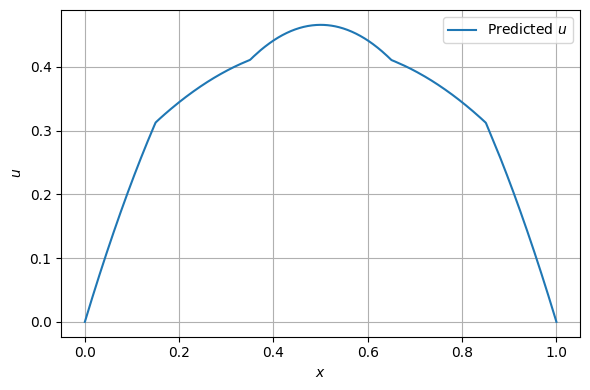

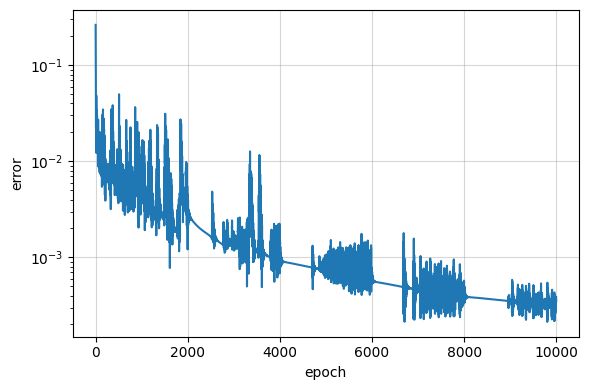

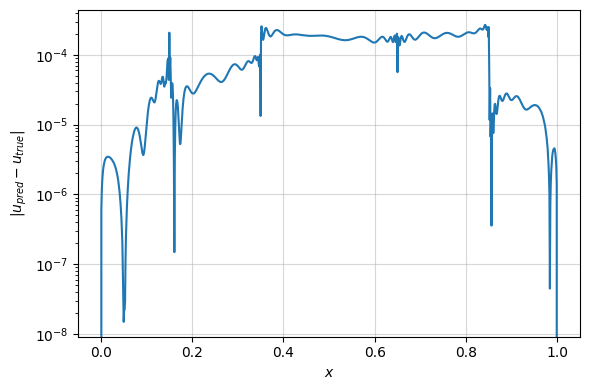

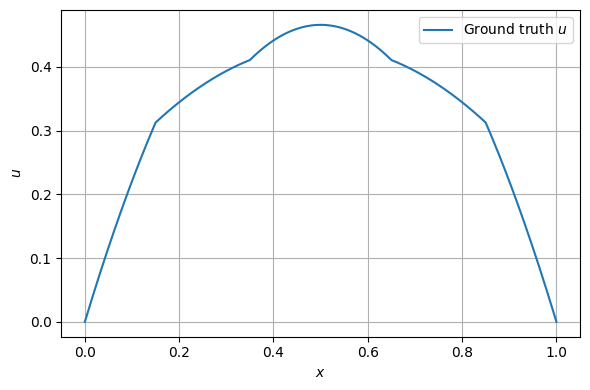

In [15]:
## Query points for prediction
x_query = x_test.to(device)
# Predict the displacement field u at query points
u_query = u_model_hard(x_query)
u_query = mollifier(u_query, x_query)
u_query = u_query.detach().cpu()

print(r"The absolute $L^2$ relative error is:", error_class().item())

# Plot 1: Prediction vs. True
fig1, ax1 = plt.subplots(figsize=(6, 4))
plot_prediction(x_query, u_query, x_test, u_test, ax1)
fig1.tight_layout()
fig1.savefig("task1_hard_pred.pdf")
plt.show()

# Plot 2: Error vs. Epoch
fig2, ax2 = plt.subplots(figsize=(6, 4))
plot_error_list(error_list_hard, ax2)
fig2.tight_layout()
fig2.savefig("task1_hard_error_vs_epoch.pdf")
plt.show()

# Plot 3: Pointwise absolute error
fig3, ax3 = plt.subplots(figsize=(6, 4))
plot_pointwise_absolute_error(u_test, u_query, x_query, ax3)
fig3.tight_layout()
fig3.savefig("task1_hard_pointwise_absolute_error_soft.pdf")
plt.show()

# Plot 4: Ground truth
fig4, ax4 = plt.subplots(figsize=(6, 4))
plot_true(x_query, u_query, x_test, u_test, ax4)
fig4.tight_layout()
fig4.savefig("task1_hard_true.pdf")
plt.show()
plt.show()